In [1]:
import numpy as np
import wisps
import wisps.simulations as wispsim
import pandas as pd
import splat
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from scipy.interpolate import interp1d
import numba
from tqdm import tqdm
import splat.empirical as spem
import wisps.simulations.effective_numbers as ef 
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import Normalize
import matplotlib as mpl
import splat.empirical as spe

%matplotlib inline

In [2]:
pnts=wisps.OBSERVED_POINTINGS

In [3]:
def bin_by_spt_bin(sp_types, number):
    ranges=[[17, 20], [20, 25], [25, 30], [30, 35], [35, 40]]
    numbers=[]
    for r in ranges:
        idx= np.logical_and((r[0]<=sp_types), (r[1]>sp_types))
        numbers.append(np.nansum(number[idx]))
    return numbers

def iswithin_mag_limits(mags, pnt):
    #mgs is a dictionary
    flags=[]
    for k in pnt.mag_limits.keys():
        if k =='F110' and pnt.survey =='hst3d':
            flags.append(True)
        else:
            flags.append(mags[k] < pnt.mag_limits[k])
    return np.logical_or.reduce(flags)


In [4]:
sgrid=wispsim.SPGRID

In [5]:
cands=pd.read_pickle(wisps.LIBRARIES+'/candidates.pkl')

In [6]:
tab=wisps.Annotator.reformat_table(cands)

In [7]:
pnt_names=[x.name for x in pnts]

In [8]:
pnt_names.index('par1')

149

In [9]:
def get_pointing(grism_id):
    if grism_id.startswith('par'):
        pntname=grism_id.lower().split('-')[0]
    else:
        pntname=grism_id.lower().split('-g141')[0]
    loc=pnt_names.index(pntname)
    return np.array(pnts)[loc]

In [10]:
tab['pnt']=tab['grism_id'].apply(get_pointing)

In [11]:
tab['spt_val']=np.vstack(tab.spt.values)[:,0]

In [12]:
obsmgs=tab[['F140W', 'F110W', 'F160W']].rename(columns={"F110W": "F110", 
                                                                    "F140W": "F140",
                                                                    "F160W": "F160"}).to_dict('records')
flags=[iswithin_mag_limits(x, y) for x, y in zip(obsmgs, tab.pnt.values)]

cdf_to_use=tab[flags]
nobs=wisps.custom_histogram(cdf_to_use.spt_val.apply(wisps.make_spt_number), sgrid, 1)

In [13]:
spgrid2=['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0']
cnorm=Normalize(wispsim.HS[0], wispsim.HS[-1])

In [14]:
data=(ef.simulation_outputs()['baraffe2003'])[100]

In [15]:
data.keys()

dict_keys(['f110', 'f140', 'f160', 'd', 'r', 'z', 'appf140', 'appf110', 'appf160', 'snrj', 'sl', 'pnt', 'spts', 'teff'])

In [16]:
def compute_simulated_numbers(hidx, model='saumon2008', selection='prob'):
    #an index in accordance with the scale height
    
    data=(ef.simulation_outputs()[model])[hidx]

    simdf=pd.DataFrame()
    simdf['spt']=data['spts'].flatten()
    simdf['teff']=data['teff'].flatten()
    simdf['slprob']=data['sl']
    simdf['snr']=data['snrj']
    simdf['appF140']=data['appf140']
    simdf['appF110']=data['appf110']
    simdf['appF160']=data['appf160']
    simdf['pntname']=data['pnt']
    
    simdf['pnt']=simdf.pntname.apply(lambda x: np.array(pnts)[pnt_names.index(x)])
    
    simmgs=simdf[['appF140', 'appF110', 'appF160']].rename(columns={"appF110": "F110", 
                                                                    "appF140": "F140",
                                                                    "appF160": "F160"}).to_dict('records')
    flags=[iswithin_mag_limits(x, y) for x, y in zip(simmgs,  simdf.pnt.values)]
    
    
    cutdf=(simdf[flags]).reset_index(drop=True)
    NORM = 0.63*(10**-3)/ len(cutdf.teff[np.logical_and(cutdf.teff>=1650, cutdf.teff <=1800)])
    
    NSIM=dict(zip(wispsim.SPGRID,np.zeros(len(wispsim.SPGRID))))
    #rounded spectral type
    cutdf['spt_r']=cutdf.spt.apply(np.round)
    for g in cutdf.groupby('spt_r'):
        NSIM[g[0]]=np.nansum((g[1]).slprob*NORM)
        
    return {model: {hidx:NSIM}}

In [17]:
volumes=[]
for pnt in pnts:
    vs=[]
    for h in wispsim.HS:
        vsx=[]
        for g in wispsim.SPGRID:
            vsx.append((pnt.volumes[h])[g])
        vs.append(vsx)
    volumes.append(vs)
volumes=np.array(volumes)

In [18]:
VOLUMES=np.nansum(volumes, axis=0)*4.1*(u.arcmin**2).to(u.radian**2)

In [19]:
import seaborn as sns
#flatui =['#001f3f', '#0074D9', '#7FDBFF', '#39CCCC', '#3D9970', '#2ECC40', '#01FF70', '#FFDC00']
sns.set_palette(sns.color_palette("husl"))
#sns.set_palette(sns.color_palette(flatui, len(wispsim.HS)))

In [20]:
import dask
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB',  silence_logs='error')
client

Client Scheduler: inproc://192.168.0.2/28105/1 Dashboard: http://192.168.0.2:8787/status,Cluster Workers: 1 Cores: 4 Memory: 2.00 GB


In [21]:
y2=bin_by_spt_bin(wispsim.SPGRID,nobs)
dy2=np.sqrt(y2)
lazy_results = []
for model in ['saumon2008', 'baraffe2003', 'marley2019', 'phillips2020']:
    for idx, h in enumerate(wispsim.HS):
        lazy_result= dask.delayed(compute_simulated_numbers)(h, model=model)
        lazy_results.append(lazy_result)

In [22]:
nexpct=dask.compute(*lazy_results)

In [23]:
nexpct=np.array(nexpct)

In [24]:
ds = nexpct
NUMBERS = {}
for k in ['saumon2008', 'marley2019', 'phillips2020', 'baraffe2003']:
    ds0={}
    for j in ds:
        if k in j.keys():
            key=[x for x in j[k].keys()][0]
            ds0.update({key: [(j[k][key])[yi] for yi in wispsim.SPGRID]})
    NUMBERS[k]=np.vstack([ds0[k] for k in wispsim.HS])

In [25]:
(NUMBERS['saumon2008']).shape, VOLUMES.shape

((7, 25), (7, 25))

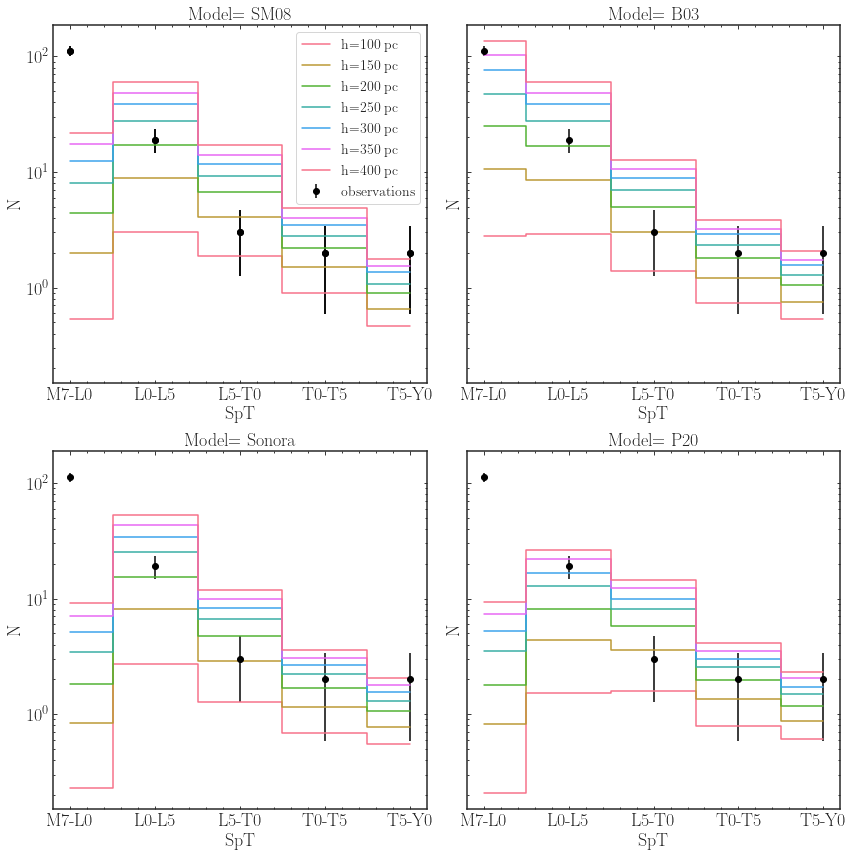

In [26]:
fig, ax=plt.subplots(figsize=(12, 12), ncols=2, nrows=2, sharey=True, sharex=False)
for model, a in zip(['saumon2008', 'baraffe2003', 'marley2019', 'phillips2020'], np.concatenate(ax)):
    
    for idx, h in enumerate(wispsim.HS):
        
        ns=None
        ns=((NUMBERS[model])[idx])*VOLUMES[idx]
        
        a.step(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns), 
                     where='mid', label='h={} pc'.format(h))
    
    a.set_yscale('log')
    a.errorbar(spgrid2,y2, yerr=dy2,fmt='o', color='k')
    a.set_xlabel('SpT',fontsize=18)
    a.set_ylabel('N',fontsize=18)
    a.minorticks_on()
        


ax[0][0].set_title('Model= SM08', fontsize=18)
ax[0][1].set_title('Model= B03', fontsize=18)
ax[1][0].set_title('Model= Sonora', fontsize=18)
ax[1][1].set_title('Model= P20', fontsize=18)

ax[0][0].errorbar(spgrid2,y2, yerr=dy2,fmt='o', color='k', label='observations')
ax[0][0].legend(fontsize=14, loc='upper right')



plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/oberved_numbers.pdf', bbox_inches='tight')

